In [140]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim

# edgeitems : 大きなテンソルは見にくいのでテンソルを表示する際に、先頭2つと末尾2つのみに制限する
# linewidth : テンソルを1行に表示する際の最大幅を指定します。テンソルがこの幅を超える場合、改行されます。
torch.set_printoptions(edgeitems=2, linewidth=75)

In [141]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # 後ろに1次元追加
t_u = torch.tensor(t_u).unsqueeze(1)

t_c.shape

torch.Size([11, 1])

In [142]:
n_sample = t_u.shape[0]
n_val = int(0.2 * n_sample)

# 0からn-1までの順列が作成され、ランダムに並び替えられる。
shuffled_indices = torch.randperm(n_sample)
# shuffled_indicesの内、先頭から(-3)までの値を取得
train_indices = shuffled_indices[:-n_val]
# shuffled_indicesの内、(-2)から末尾までの値を取得
val_indices = shuffled_indices[-n_val:]

train_indices.shape, val_indices.shape

(torch.Size([9]), torch.Size([2]))

In [143]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = t_u_train * 0.1
t_un_val = t_u_val * 0.1
t_un_train.shape, t_un_val.shape

(torch.Size([9, 1]), torch.Size([2, 1]))

### 6.2.1 __call__を使用する

In [144]:
linear_model = nn.Linear(1, 1) # 入力1次元、出力1次元
linear_model(t_u_val)

tensor([[-24.9425],
        [-59.7101]], grad_fn=<AddmmBackward0>)

In [145]:
linear_model.weight

Parameter containing:
tensor([[-0.7243]], requires_grad=True)

In [146]:
linear_model.bias

Parameter containing:
tensor([-0.3879], requires_grad=True)

### バッチ入力

In [147]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-1.1123],
        [-1.1123],
        ...,
        [-1.1123],
        [-1.1123]], grad_fn=<AddmmBackward0>)

In [148]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

In [149]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch} Training loss {loss_train:.4f} Validation loss {loss_val:.4f}')

In [150]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1000 Training loss 4.5958 Validation loss 10.9817
Epoch 2000 Training loss 2.8841 Validation loss 5.2715
Epoch 3000 Training loss 2.7453 Validation loss 4.7438

Parameter containing:
tensor([[5.2408]], requires_grad=True)
Parameter containing:
tensor([-17.0207], requires_grad=True)


### ニューラルネットワークの構築

In [151]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(1, 13)
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=13, bias=True)
)

In [152]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([13, 1]), torch.Size([13])]

In [153]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([13, 1])
2.bias torch.Size([13])


### レイヤーに名前をつける

In [154]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [155]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [156]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1000 Training loss 3.7749 Validation loss 45.6866
Epoch 2000 Training loss 2.2807 Validation loss 27.6226
Epoch 3000 Training loss 1.8747 Validation loss 20.4442
Epoch 4000 Training loss 2.2387 Validation loss 18.9525
Epoch 5000 Training loss 1.9456 Validation loss 16.3047
output tensor([[-0.1863],
        [24.0032]], grad_fn=<AddmmBackward0>)
answer tensor([[ 3.],
        [28.]])
hidden tensor([[-13.7124],
        [ 19.7647],
        ...,
        [ -8.6801],
        [ -0.0898]])


### 線形モデルとの比較

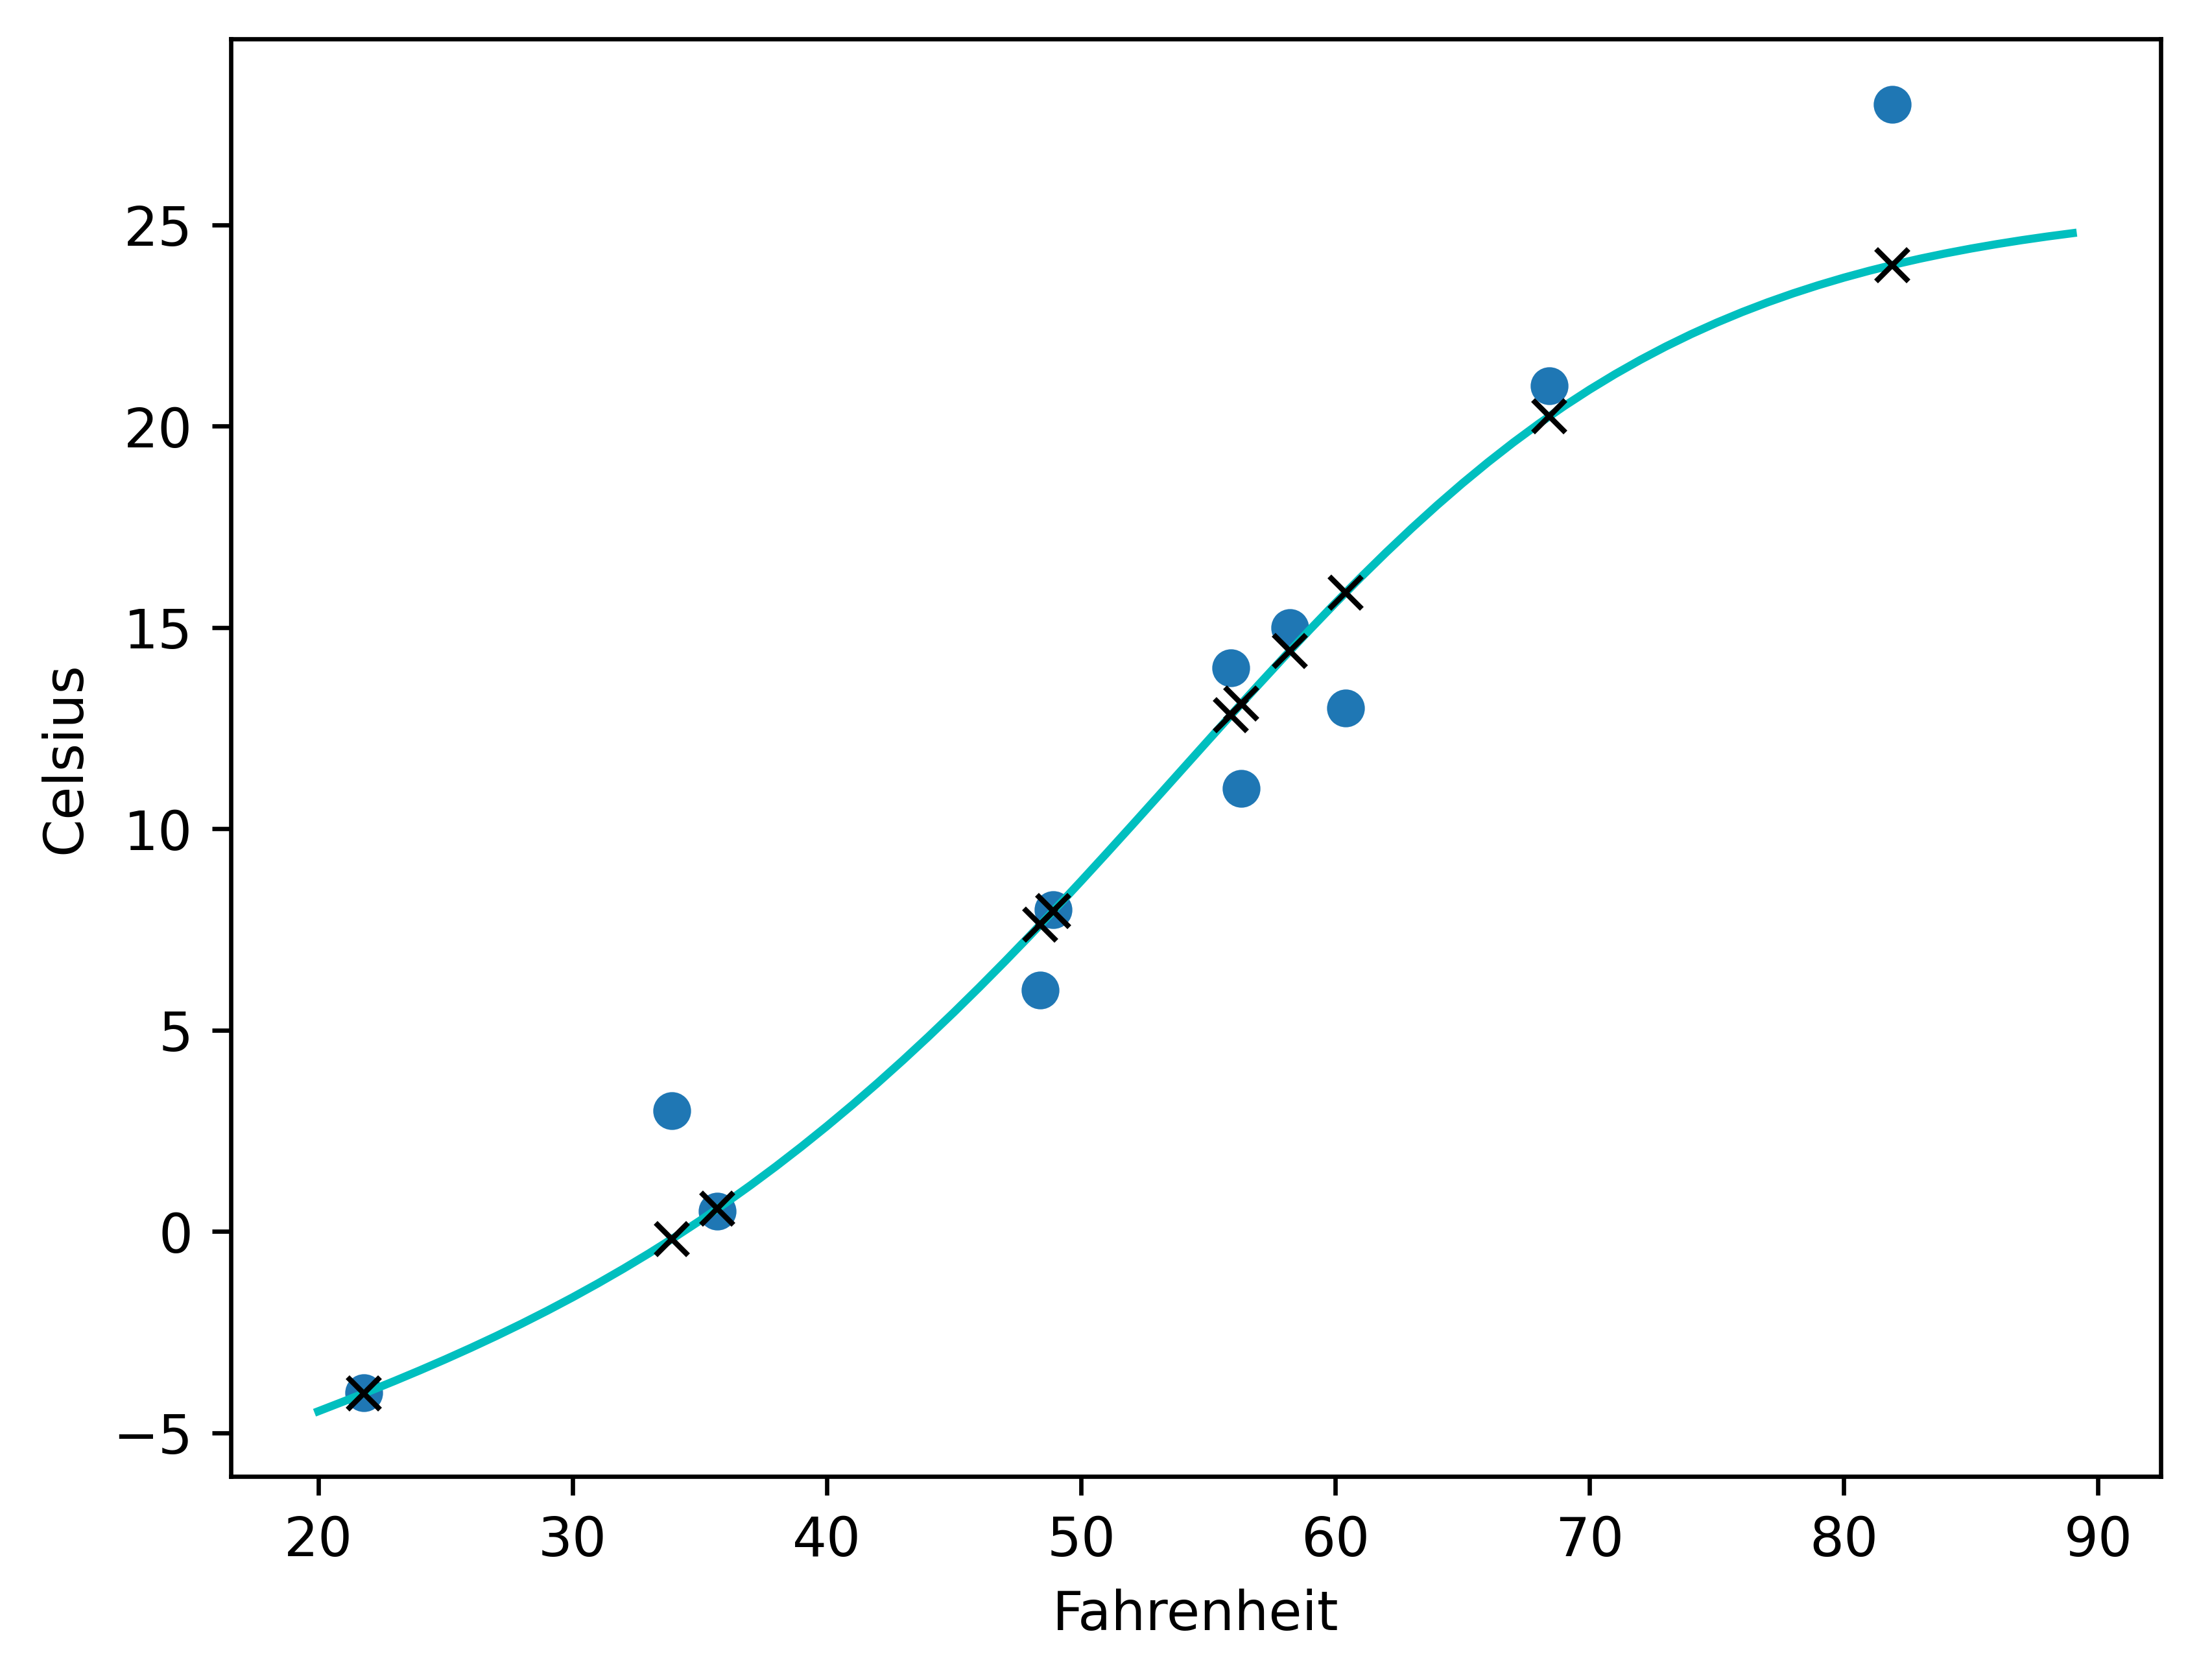

In [157]:
from matplotlib import pyplot as plt

# 20~89の値を生成
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), "c-")
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')